A QR code's fundamental unit as a module, which is one square of the grid the pattern is encoded on. The finder patterns consist of a 3x3 black square on a 5x5 white square on a 7x7 black square, making bands of 1 module thickness around the centre 3x3 square. A line across this at any point will have roughly the same ratio of black/white/black/white/black, even through rotation!

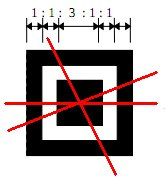

In [1]:
%matplotlib notebook

import cv2 as cv
import numpy as np
import math
from itertools import permutations
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
THRESH = 140

In [122]:
im = cv.imread("Qr-2-scansim.png")
bw_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
_, thresh_im = cv.threshold(bw_im, 128, 255, cv.THRESH_BINARY)

In [7]:
class QRException(Exception):
    pass

In [3]:
def rotate_about_point(vector, point, angle):
    sin = math.sin(angle)
    cos = math.cos(angle)
    M = np.array([[cos, -sin],[sin, cos]])
    return point + np.dot(M, (vector - point))

def angle_between(a, b):
    x = 1
    y = 0
    return np.arctan2(a[x]*b[y] - a[y]*b[x],
                      a[x]*b[x] + a[y]*b[y])

In [4]:
class Line:
    def __init__(self, start, end):
        self.start = np.array(start)
        self.end = np.array(end)
        self._center = None
        self._length = None
        self._vector = None
        
    def __repr__(self):
        return f"Line(start={tuple(self.start)}, end={tuple(self.end)})"
        
    @property
    def center(self):
        if self._center is None:
            self._center = (self.start+self.end)/2
        return self._center
    
    @property
    def length(self):
        if self._length is None:
            self._length = np.linalg.norm(self.end - self.start)
        return self._length
    
    @property
    def vector(self):
        if self._vector is None:
            self._vector = self.end - self.start
        return self._vector
    
    def rot90(self):
        rot = np.array([[0, 1],[-1, 0]])
        start = self.center + np.dot(
            rot,(self.start - self.center))
        end = self.center + np.dot(
            rot, (self.end - self.center))
        return type(self)(start, end)
    
    def rot45(self):
        angle = -math.pi/4
        start = rotate_about_point(
            self.start, self.center, angle)
        end = rotate_about_point(
            self.end, self.center, angle)
        return type(self)(start, end)
    
    def grow(self, ratio):
        start = (self.start - self.center) * ratio + self.center
        end = (self.end - self.center) * ratio + self.center
        return type(self)(start, end)

    def left_to_right(self):
        if self.start[1] > self.end[1]:
            return type(self)(self.end, self.start)
        else:
            return self
        
    def plot(self, ax, *args, **kwargs):
        ax.plot(*list(zip(self.start, self.end))[::-1],
                *args, **kwargs)


In [6]:
class QRFinder:
    def __init__(self, im, skip_rows=3, ax=None):
        self.skip_rows = skip_rows
        self.possible_centers = []
        self.im = im
        self.ax = ax
        if ax is not None:
            ax.imshow(im, cmap=plt.get_cmap('gray'))
        
    def find(self):
        p1 = [0, 0]
        p2 = [0, self.im.shape[1]]
        while p1[0] < self.im.shape[0]:
            possible_patt = self.check_line(Line(p1, p2))
            while possible_patt:
                self.handle_possible_patt(possible_patt)
                p1[1] = possible_patt.end[1]
                possible_patt = self.check_line(Line(p1, p2))
            p1[0] += self.skip_rows
            p2[0] = p1[0]
            p1[1] = 0
        for c in self.possible_centers:
            self._plot(c)
        return len(self.possible_centers) > 0
    
    def _plot(self, thing):
        if self.ax is not None:
            if type(thing) is Line:
                thing.plot(self.ax)
            else:
                self.ax.plot(*thing[::-1], 'r+')

    def handle_possible_patt(self, line):
        tolerance = math.sqrt(2) * 1.1
        
        self._plot(line)

        # check vertical
        vert = self.check_line(line.rot90().grow(tolerance))
        if not vert:
            return False
        self._plot(vert)

        # check new horizontal
        hor = self.check_line(
            vert.rot90().left_to_right().grow(tolerance))
        if not hor:
            return False
        self._plot(hor)

        # check diagonal
        diag = self.check_line(hor.rot45().grow(tolerance))
        if not diag:
            return False
        self._plot(diag)

        new_center = hor.center
        new = True
        for i, center in enumerate(self.possible_centers):
            if np.linalg.norm(center - new_center) < 10:
                self.possible_centers[i] = (center + new_center)/2
                new = False
        if new:
            self.possible_centers.append(new_center)
        return True

    def check_line(self, line):
        counts = [0] * 5
        black_starts = []
        current_state = -1
        col = int(line.start[1])
        row = int(line.start[0])
        lcol = col
        lrow = row
        while (int(Line((row,col), line.end).length) > 0
               and row < self.im.shape[0]
               and col < self.im.shape[1]):
            pix = self.im[row, col]
            if pix < THRESH:
                # black pixel
                if current_state in (-1, 1, 3):
                    # but we're counting white
                    current_state += 1
                    black_starts.append((row, col))
            else:
                # white pixel
                if current_state in (0, 2):
                    # but we're counting black
                    current_state += 1
                elif current_state == 4:
                    # valid pattern?
                    if self.check_ratio(counts):
                        possible_start = black_starts[0]
                        return Line(possible_start, (lrow, lcol))
                    else:
                        # no, but don't discard all the counts;
                        # a finder pattern could have started 
                        # part way through this one
                        del black_starts[:1]
                        del counts[:2]
                        counts.extend([0] * 2)
                        current_state = 3
            if current_state >= 0:
                counts[current_state] += 1
            lrow = row
            lcol = col
            if row < line.end[0]:
                row += 1
            if col < line.end[1]:
                col += 1
        return False
        
    @staticmethod
    def check_ratio(counts):
        if 0 in counts:
            return False
        total = sum(counts)
        if total < 7:
            # The minimum module size is 1 pixel
            return False
        
        module_s = math.ceil(total / 7)
        tolerance = module_s / 2
        counts = counts[:]
        counts[2] /= 3
        
        return all([abs(module_s - count) < tolerance for count in counts])
    


In [233]:
class QRReader:
    def __init__(self, finders, im, ax=None):
        self.im = im
        self.ax = ax
        self.identify_finders(finders)
        self._plot()
        self.module_size = None
        self.dimension = None
        self.version = None
        
    def _plot(self):
        if self.ax is not None:
            self.ax.clear()
            self.ax.imshow(self.im, cmap=plt.get_cmap('gray'))
            self.top.plot(self.ax, 'b')
            self.left.plot(self.ax, 'g')
            for p in self.tl, self.tr, self.bl:
                self.ax.plot(*p[::-1], '+r')
    
    def _plot_point(self, col, row, f='+m'):
        if self.ax is not None:
            self.ax.plot(col, row, f)
    
        
    def identify_finders(self, finders):
        """Identify which of the finders is the top-left,
        top-right, and bottom-left."""
        assert len(finders) == 3, "There must be three finders"
        goal_angle = math.pi/2  # 90 degrees
        
        # try each one as the top-left finder
        for i in range(len(finders)):
            tl = finders[i]
            
            # try one assignment of top-right and bottom-left
            tr = finders[i-2]
            bl = finders[i-1]
            
            top = Line(tl, tr)
            left = Line(tl, bl)
            
            angle = angle_between(tr - tl, bl - tl)
            
            # is the angle within tolerance of 90 degrees?
            if abs(abs(angle) - goal_angle) < 0.1:
                self.tl = tl
                if angle > 0:
                    # if the assignment of tr/bl was correct
                    self.tr = tr
                    self.bl = bl
                else:
                    # if it wasn't, swap them
                    self.tr = bl
                    self.bl = tr
                self.top = Line(self.tl, self.tr)
                self.left = Line(self.tl, self.bl)
                return
        raise QRException("Can't identify finders")
        
    def _affine_transform(self, src_pts, dst_pts, size, **kwargs):
        M = cv.getAffineTransform(src_pts, dst_pts)
        
        # perform the transform
        self.im = cv.warpAffine(self.im, M, (size, size), **kwargs)

        #_, self.im = cv.threshold(self.im, 128, 255, cv.THRESH_BINARY)
        
        # transform the finder pattern locations too
        self.tl = np.dot(M, np.append(self.tl[::-1], [1]))[::-1]
        self.tr = np.dot(M, np.append(self.tr[::-1], [1]))[::-1]
        self.bl = np.dot(M, np.append(self.bl[::-1], [1]))[::-1]
        self.top = Line(self.tl, self.tr)
        self.left = Line(self.tl, self.bl)
        
        self._plot()
    
    def correct_rotation(self, size=100, **kwargs):
        """Perform an affine transformation to move the
        three finder points into known positions
        
        size: the side length of the transformed image"""
        
        border = int(size * 0.15)
        # the reference points
        src_pts = np.float32([self.tl[::-1],
                          self.tr[::-1],
                          self.bl[::-1]])
        # where they should be in the final image
        dst_pts = np.float32([[border,border],
                          [size-border, border],
                          [border, size-border]])
        
        self._affine_transform(src_pts, dst_pts, size, **kwargs)

        
    def find_module_size(self, thresh=128):
        """Find a fairly accurate module size by walking
        along the timing pattern. Make sure correct_rotation was
        called before this, or this will fail"""
        
        # walk down to finder pattern border
        state = 'start'
        down_count = 1
        row = int(round(self.tl[0]))
        col = int(round(self.tl[1]))
        while row < self.im.shape[0]:
            pix = self.im[row, col]
            if pix < thresh:
                # black pixel
                if state == 'white':
                    self._plot_point(col, row, '+c')
                    state = 'black'
                elif state == 'black':
                    down_count += 1
            else:
                # white pixel
                if state == 'start':
                    self._plot_point(col, row, '+c')
                    state = 'white'
                elif state == 'black':
                    self._plot_point(col, row, '+c')
                    break
            row += 1
        row = int(row - down_count / 2)
        self._plot_point(col, row)
        
        # walk along the timing pattern
        state = 'start' # will be either 'white' or 'black'
        count = 0
        found_modules = []
        
        # Initialise it to something larger than the largest possible
        # The largest possible is the width divided by 16, so the width
        # divided by ten should always be bigger.
        module_size = self.top.length / 10
        
        # walk until the edge of the image or until the 
        # timing pattern seems to end
        while (col < self.im.shape[1] 
               and count < (module_size * 1.5)):
            pix = self.im[row, col]
            if pix < thresh:
                # black pixel
                if state == 'white':
                    self._plot_point(col, row)
                    state = 'black'
                    module_size = self.check_timing_module(
                        found_modules,
                        count,
                        module_size)
                    count = 1
                elif state == 'black':
                    count += 1
            else:
                # white pixel
                if state == 'black':
                    self._plot_point(col, row)
                    state = 'white'
                    module_size = self.check_timing_module(
                        found_modules,
                        count,
                        module_size)
                    count = 1
                elif state == 'white':
                    count += 1
                elif state == 'start':
                    self._plot_point(col, row)
                    state = 'white'
                    count = 1
            col += 1
        self.module_size = module_size
        return module_size
    
    @staticmethod
    def check_timing_module(modules, count, size):
        errors = 0
        tolerance = round(size/2)
        for m in modules:
            if abs(m-count) > tolerance:
                errors += 1
        if not errors < 2:
            raise QRException(f"Invalid timing pattern. \nmodules={modules}, count={count}, tolerance={tolerance}, errors={errors}")
        modules.append(count)
        return sum(modules)/len(modules)
    
    def get_version(self):
        if self.module_size is None:
            raise QRException("Call find_module_size first")
        width = self.top.length
        height = self.left.length
        
        # The centers of the finder patterns are 3.5 modules from the edge. 
        # Therefore the actual width in modules is the width between the centers +
        # 2 * 3.5 = 7.
        dimension = int(round(((width/self.module_size + height/self.module_size) / 2) + 7))
        
        
        # the dimension of a QR code is always 4n+1, where n is the version + 4.
        # this forces the dimension to match this. not using for now as the dimension
        # seems accurate without it.
        # corrected_dim = {0: dimension + 1, 1: dimension,
        #                  2: dimension - 1, 3: dimension - 2}[round(dimension) % 4]

        
        # the dimension of a QR code is always 4 * version number + 17.
        # this is a second method of getting this number.
        version = (dimension - 17)//4
        
        self.dimension = dimension
        self.version = version
        return dimension, version
    
    def to_binary(self):
        if self.dimension is None:
            raise QRException("Call get_version first")
        
        out = np.empty((self.dimension, self.dimension))
        
        step = int(round(self.module_size))
        row, col = self.tl - [int(3.5 * step)]*2
        row, col = int(round(row)), int(round(col))
        while row < self.im.shape[0]-step and col < self.im.shape[1]-step:
            values = sorted(self.im[row*step:(row+1)*step, col*step:(col+1)*step].flat)
            out[row, col] = values[len(values)//2]
            row += 1
            col += 1
            
        return binary
        
            
    
    def extract_bits(self):
        pass

In [204]:
plt.close('all')

<IPython.core.display.Javascript object>


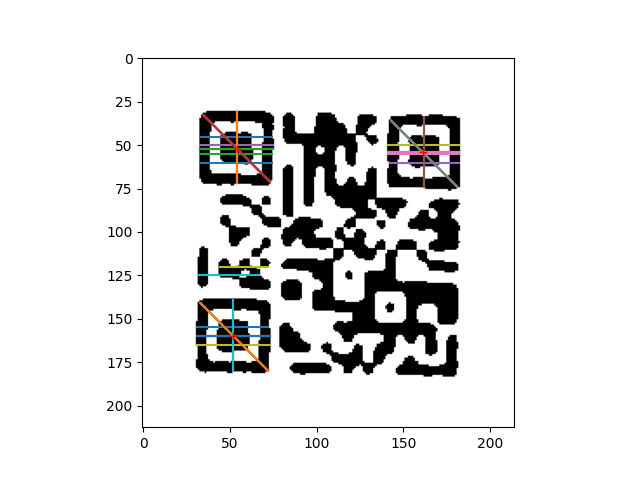

True

In [205]:
fig, ax = plt.subplots()
finder = QRFinder(thresh_im, skip_rows=5, ax=ax)
finder.find()

<IPython.core.display.Javascript object>


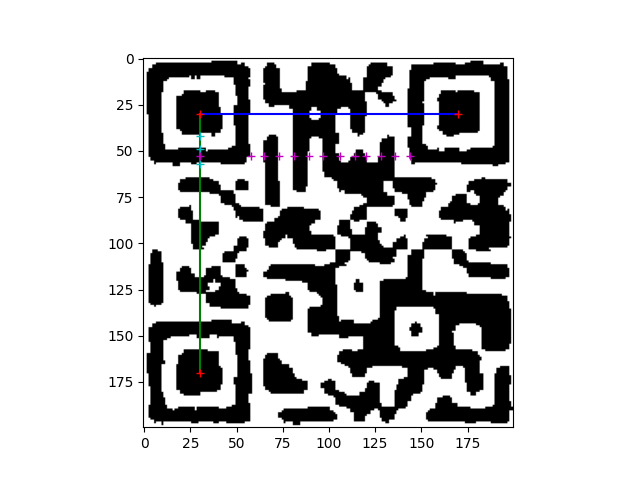

In [234]:
fig, ax = plt.subplots()
reader = QRReader(finder.possible_centers, thresh_im, ax=ax)
reader.correct_rotation(200, flags=cv.INTER_NEAREST)

In [235]:
reader.find_module_size()

7.818181818181818

In [236]:
reader.get_version()

(25, 2)

<IPython.core.display.Javascript object>


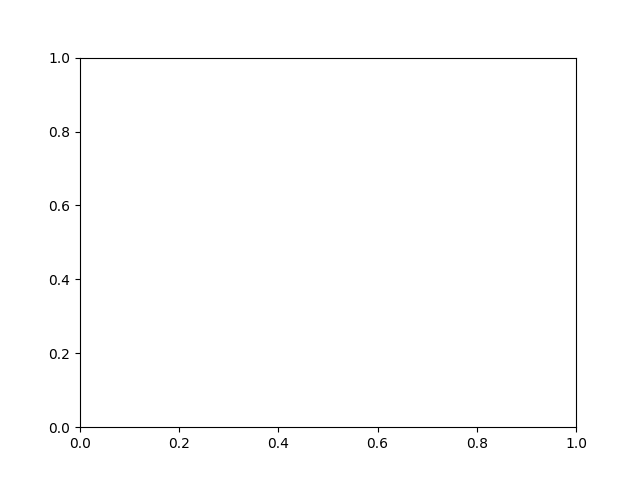

IndexError: list index out of range

In [237]:
fig, ax = plt.subplots()
as_bin = reader.to_binary()
ax.imshow(as_bin, cmap=plt.get_cmap('gray'))

In [79]:
rows, cols = bw_im.shape
rotmat = cv.getRotationMatrix2D((cols/2,rows/2), 45, 1)
im_rot = cv.warpAffine(bw_im, rotmat, (cols, rows), cv.INTER_LINEAR, cv.BORDER_REFLECT)

<IPython.core.display.Javascript object>


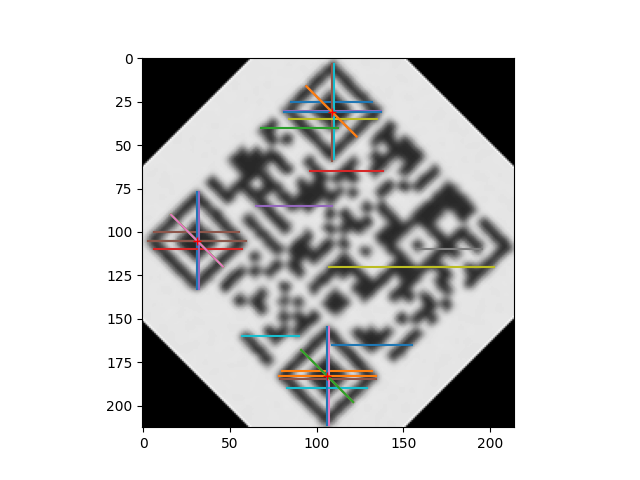

True

In [80]:
fig, ax = plt.subplots()
rot_finder = QRFinder(im_rot,5, ax=ax)
rot_finder.find()

<IPython.core.display.Javascript object>


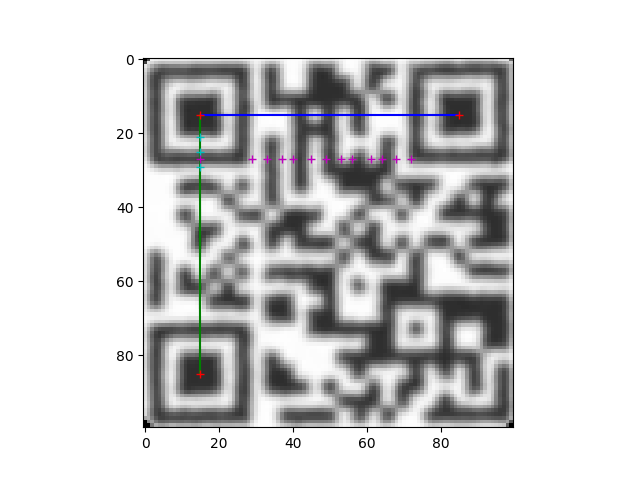

In [81]:
fig, ax = plt.subplots()
rot_reader = QRReader(rot_finder.possible_centers, im_rot, ax=ax)
rot_reader.correct_rotation()

In [82]:
rot_reader.find_module_size()

3.909090909090909

In [83]:
rot_reader.get_version()

(25, 2)